In [50]:
from xgboost import XGBRegressor

import sys
if '..' not in sys.path:
    sys.path.append('..')

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
import tqdm
import gzip
import multiprocessing.pool

import utils

In [3]:
FEAT_ROOT = '../runs/unet-limit500/'
# FEAT_ROOT = '../runs/unet-limit100-nolw0.1-lr0.0002/'

In [5]:
def load_pred(path):
    with gzip.open(str(path), 'rb') as f:
        return np.load(f).astype(np.float32) / 1000

In [12]:
IMG_ID = 200
img = utils.load_image(Path('../data/Train/{}.jpg'.format(IMG_ID)), cache=False)
pred = load_pred('{}/{}-pred.npy'.format(FEAT_ROOT, IMG_ID))
img.shape, pred.shape

((3328, 4992, 3), (6, 3328, 4992))

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(img);

In [ ]:
size = (1000, 600)
small_img = cv2.resize(img, size)
pred_sum = pred[:utils.N_CLASSES].sum(axis=0)

#"""
for cls in range(utils.N_CLASSES):
    plt.figure(figsize=(16, 12))
    plt.imshow(small_img)
    plt.imshow(cv2.resize(pred[cls], size), alpha=0.5)
    plt.show()
#"""

plt.figure(figsize=(16, 12))
plt.imshow(small_img)
plt.imshow(cv2.resize(pred_sum, size), alpha=0.7)
plt.show()

In [15]:
all_coords = utils.load_coords()

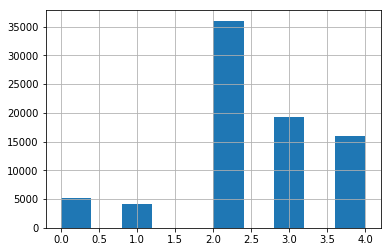

In [7]:
all_coords.cls.hist()

In [60]:
def load_xs_ys(pred_path):
    pred = load_pred(pred_path)
    img_id = int(pred_path.name.split('-')[0])
    xs, ys = [], []
    for cls in range(utils.N_CLASSES):
        try:
            ys.append(
                (all_coords.loc[img_id].cls == cls).sum())
        except KeyError:
            ys.append(0)
        cls_pred = pred[cls]
        x = []
        thresholds = [0.02, 0.25] #, 0.05, 0.25, 0.5]
        for i, threshold in enumerate(thresholds):
            bin_mask = cls_pred > threshold
            if i + 1 < len(thresholds):
                bin_mask &= cls_pred < thresholds[i + 1]
            x.append(bin_mask.sum())
        x.append(cls_pred.sum())  # FIXME correlated with x[0]?
        xs.append(x)
    return xs, ys

all_xs = [[] for _ in range(utils.N_CLASSES)]
all_ys = [[] for _ in range(utils.N_CLASSES)]
with multiprocessing.pool.ThreadPool(processes=6) as pool:
    img_paths = list(Path(FEAT_ROOT).glob('*-pred.npy'))
    print('{} total'.format(len(img_paths)))
    for i, (xs, ys) in enumerate(pool.imap_unordered(load_xs_ys, img_paths, chunksize=2)):
        if i % 50 == 0:
            print(i)
        for cls in range(utils.N_CLASSES):
            all_xs[cls].append(xs[cls])
            all_ys[cls].append(ys[cls])
all_xs = np.array(all_xs)
all_ys = np.array(all_ys)

548 total
0
50
100
150
200
250
300
350
400
450
500


In [17]:
for cls in range(utils.N_CLASSES):
    print(all_xs[cls][:, 0].mean())

13537.36
13060.31
55115.25
42394.89
27809.73


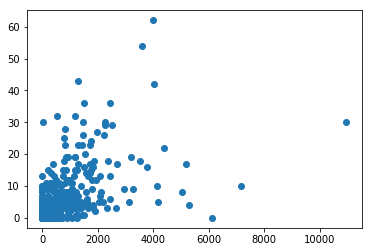

In [63]:
plt.scatter(all_xs[0][:, 1], all_ys[0])

In [85]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from IPython.core.display import display
from eli5 import show_weights
from sklearn.dummy import DummyRegressor

def evaluate(reg):
    print()
    all_rmse = []
    for cls in range(utils.N_CLASSES):
        xs, ys = all_xs[cls], all_ys[cls]
        rmse = np.sqrt(-cross_val_score(reg, xs, ys, scoring='neg_mean_squared_error', cv=5))
        print('cls {}, target mean {:.2f}, RMSE {:.2f} +- {:.2f}'.format(
            cls, np.mean(ys), np.mean(rmse), 2 * np.std(rmse)))
        all_rmse.append(np.mean(rmse))
        # reg.fit(xs, ys)
        # display(show_weights(reg, target_names=['cls-{}'.format(cls)]))
    print('Average RMSE for {}: {:.2f}'.format(type(reg), np.mean(all_rmse)))

evaluate(DummyRegressor())
  
evaluate(Lasso(alpha=1.0, normalize=False, max_iter=100000))      


cls 0, target mean 5.27, RMSE 7.34 +- 1.75
cls 1, target mean 4.29, RMSE 6.19 +- 1.94
cls 2, target mean 37.08, RMSE 69.94 +- 17.84
cls 3, target mean 21.16, RMSE 46.29 +- 19.09
cls 4, target mean 16.30, RMSE 49.52 +- 13.12
Average RMSE for <class 'sklearn.dummy.DummyRegressor'>: 35.86

cls 0, target mean 5.27, RMSE 6.09 +- 1.67
cls 1, target mean 4.29, RMSE 6.00 +- 1.46
cls 2, target mean 37.08, RMSE 40.49 +- 4.29
cls 3, target mean 21.16, RMSE 34.79 +- 12.41
cls 4, target mean 16.30, RMSE 28.87 +- 9.79
Average RMSE for <class 'sklearn.linear_model.coordinate_descent.Lasso'>: 23.25


In [88]:
evaluate(XGBRegressor(n_estimators=10, max_depth=2))


cls 0, target mean 5.27, RMSE 6.44 +- 1.82
cls 1, target mean 4.29, RMSE 6.05 +- 1.98
cls 2, target mean 37.08, RMSE 49.54 +- 15.04
cls 3, target mean 21.16, RMSE 34.97 +- 12.23
cls 4, target mean 16.30, RMSE 36.89 +- 14.36
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 26.78


In [91]:
evaluate(XGBRegressor(n_estimators=50, max_depth=2))


cls 0, target mean 5.27, RMSE 6.25 +- 1.46
cls 1, target mean 4.29, RMSE 6.06 +- 1.59
cls 2, target mean 37.08, RMSE 39.14 +- 14.25
cls 3, target mean 21.16, RMSE 30.40 +- 10.41
cls 4, target mean 16.30, RMSE 31.45 +- 13.19
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 22.66


In [90]:
evaluate(XGBRegressor(n_estimators=100, max_depth=2))


cls 0, target mean 5.27, RMSE 6.46 +- 1.69
cls 1, target mean 4.29, RMSE 6.32 +- 1.53
cls 2, target mean 37.08, RMSE 39.23 +- 15.35
cls 3, target mean 21.16, RMSE 30.89 +- 12.19
cls 4, target mean 16.30, RMSE 33.33 +- 13.50
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 23.25


In [86]:
def evaluate_stacked(reg):
    stacked_xs = np.concatenate(all_xs, axis=1)
    all_rmse = []
    for cls in range(utils.N_CLASSES):
        ys = all_ys[cls]
        xs = stacked_xs
        rmse = np.sqrt(-cross_val_score(reg, xs, ys, scoring='neg_mean_squared_error', cv=5))
        print('cls {}, target mean {:.2f}, RMSE {:.2f} +- {:.2f}'.format(
            cls, np.mean(ys), np.mean(rmse), 2 * np.std(rmse)))
        all_rmse.append(np.mean(rmse))
        # reg.fit(xs, ys)
        # display(show_weights(reg, target_names=['cls-{}'.format(cls)]))
    print('Average RMSE for {}: {:.2f}'.format(type(reg), np.mean(all_rmse)))

evaluate_stacked(Lasso(alpha=1.0, normalize=False, max_iter=100000))

cls 0, target mean 5.27, RMSE 4.85 +- 1.37
cls 1, target mean 4.29, RMSE 5.93 +- 1.03
cls 2, target mean 37.08, RMSE 40.45 +- 7.44
cls 3, target mean 21.16, RMSE 35.61 +- 9.19
cls 4, target mean 16.30, RMSE 25.28 +- 10.50
Average RMSE for <class 'sklearn.linear_model.coordinate_descent.Lasso'>: 22.42


In [92]:
evaluate_stacked(XGBRegressor(n_estimators=10, max_depth=2))

cls 0, target mean 5.27, RMSE 5.72 +- 1.72
cls 1, target mean 4.29, RMSE 6.04 +- 1.98
cls 2, target mean 37.08, RMSE 50.16 +- 12.26
cls 3, target mean 21.16, RMSE 35.43 +- 11.22
cls 4, target mean 16.30, RMSE 35.72 +- 10.01
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 26.61


In [97]:
evaluate_stacked(XGBRegressor(n_estimators=10, max_depth=2, objective='reg:linear'))

cls 0, target mean 5.27, RMSE 5.72 +- 1.72
cls 1, target mean 4.29, RMSE 6.04 +- 1.98
cls 2, target mean 37.08, RMSE 50.16 +- 12.26
cls 3, target mean 21.16, RMSE 35.43 +- 11.22
cls 4, target mean 16.30, RMSE 35.72 +- 10.01
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 26.61


In [93]:
evaluate_stacked(XGBRegressor(n_estimators=100, max_depth=2))

cls 0, target mean 5.27, RMSE 4.27 +- 1.24
cls 1, target mean 4.29, RMSE 5.88 +- 1.49
cls 2, target mean 37.08, RMSE 38.63 +- 10.13
cls 3, target mean 21.16, RMSE 33.50 +- 12.84
cls 4, target mean 16.30, RMSE 26.85 +- 9.80
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 21.83


In [98]:
evaluate_stacked(XGBRegressor(n_estimators=50, max_depth=2))

cls 0, target mean 5.27, RMSE 4.35 +- 1.23
cls 1, target mean 4.29, RMSE 5.87 +- 1.57
cls 2, target mean 37.08, RMSE 39.00 +- 10.58
cls 3, target mean 21.16, RMSE 33.41 +- 11.46
cls 4, target mean 16.30, RMSE 26.50 +- 11.92
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 21.82


In [99]:
evaluate_stacked(XGBRegressor(n_estimators=300, learning_rate=0.03))

cls 0, target mean 5.27, RMSE 4.35 +- 1.32
cls 1, target mean 4.29, RMSE 5.78 +- 1.46
cls 2, target mean 37.08, RMSE 38.48 +- 10.60
cls 3, target mean 21.16, RMSE 34.87 +- 11.95
cls 4, target mean 16.30, RMSE 27.36 +- 9.64
Average RMSE for <class 'xgboost.sklearn.XGBRegressor'>: 22.17
